In [12]:
import jittor as jt
from jittor import nn, Module
from jittor.dataset.cifar import CIFAR10
import jittor.transform as trans
from RNN_model import LSTMModel
from RNN_model import RNNModel
import sys, os
import random
import math
from jittor import init
import numpy as np
from jittor.dataset import DataLoader
#同CNN,继承类
class Moderated_Cifar10(CIFAR10):
    def __init__(self, root=None, train=True, transform=None, download=False):
        super().__init__(root, train=train, transform = transform, download=download)
        cnt = [0, 0, 0, 0, 0]
        indices = []
        for index, label in enumerate(self.targets):
            if label < 5:
                if cnt[label] < 500:
                    indices.append(index)
                    cnt[label] += 1
            else:
                indices.append(index)
        self.targets = [self.targets[i] for i in range(50000) if i in indices]
        mask = np.zeros(50000, dtype=bool)
        mask[indices] = True
        self.data = self.data[mask]

jt.set_seed(0)
trainlos = []
testacc = []
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.permute(0, 2, 1, 3).reshape(-1, 32, 3 * 32) #转化数据为LSTM接受的输入格式
        outputs = model(inputs)
        loss = nn.cross_entropy_loss(outputs, targets)
        optimizer.step(loss)
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx*100, len(train_loader),
                100. * batch_idx / len(train_loader), loss.data[0]))
        trainlos.append(loss.data[0])
    

def test(model, val_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total_acc = 0
    total_num = 0
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        batch_size = inputs.shape[0]
        inputs = inputs.permute(0, 2, 1, 3).reshape(batch_size, 32, 3 * 32)
        outputs = model(inputs)
        pred = np.argmax(outputs.data, axis=1)
        acc = np.sum(targets.data==pred)
        total_acc += acc
        total_num += batch_size
        acc = acc / batch_size
        print('Test Epoch: {} [{}/{} ({:.0f}%)]\tAcc: {:.6f}'.format(epoch, \
                    batch_idx, len(val_loader),100. * float(batch_idx) / len(val_loader), acc))
    print ('Total test acc =', total_acc / total_num)
    testacc.append(total_acc / total_num)

def main():
    batch_size = 100
    learning_rate = 0.01
    hidden_size = 256
    num_layers = 2
    num_classes = 10
    epoch = 5
    momentum = 0.9
    weight_decay = 1e-4 #通过改变该参数进行多次训练测试
    transform_train = trans.Compose([trans.RandomHorizontalFlip(0.5), trans.ImageNormalize(mean = [0.5], std = [0.2])])
    transform_test = trans.Compose([trans.ImageNormalize(mean = [0.5], std = [0.2])])
    '''
    在未删减的数据集上使用则改为改数据集
    dataset_train = CIFAR10(root='cifar-10-python', train=True, transform=transform_train,  download=False).set_attrs(batch_size=batch_size, shuffle=True)  
    dataset_valid = CIFAR10(root='cifar-10-python', train=False, transform=transform_test, download=False).set_attrs(batch_size=batch_size,   shuffle=False
    '''
    dataset_train = Moderated_Cifar10(root='cifar-10-python', train=True, transform=transform_train,  download=False)
    dataset_valid = CIFAR10(root='cifar-10-python', train=False, transform=transform_test, download=False)
    train_loader = DataLoader(dataset_train, batch_size=batch_size,shuffle = True, num_workers = 0)
    val_loader = DataLoader(dataset_valid, batch_size=batch_size,shuffle = False, num_workers = 0)
    model = LSTMModel(input_size=3*32, hidden_size=hidden_size, output_size=10)
    optimizer = nn.SGD(model.parameters(), learning_rate,momentum, weight_decay)
    for epoch in range(epoch):
        train(model, train_loader, optimizer, epoch)
        test(model,val_loader,epoch)

if __name__ == '__main__':
    main()


Train Epoch: 0 [0/27500 (0%)]	Loss: 2.355150
Train Epoch: 0 [100/27500 (0%)]	Loss: 2.176914
Train Epoch: 0 [200/27500 (0%)]	Loss: 2.142317
Train Epoch: 0 [300/27500 (0%)]	Loss: 2.097567
Train Epoch: 0 [400/27500 (0%)]	Loss: 2.019543
Train Epoch: 0 [500/27500 (0%)]	Loss: 1.895897
Train Epoch: 0 [600/27500 (0%)]	Loss: 1.763629
Train Epoch: 0 [700/27500 (0%)]	Loss: 1.933033
Train Epoch: 0 [800/27500 (0%)]	Loss: 1.812402
Train Epoch: 0 [900/27500 (0%)]	Loss: 2.014719
Train Epoch: 0 [1000/27500 (0%)]	Loss: 1.803798
Train Epoch: 0 [1100/27500 (0%)]	Loss: 1.875636
Train Epoch: 0 [1200/27500 (0%)]	Loss: 1.854702
Train Epoch: 0 [1300/27500 (0%)]	Loss: 1.782434
Train Epoch: 0 [1400/27500 (0%)]	Loss: 2.085028
Train Epoch: 0 [1500/27500 (0%)]	Loss: 1.930770
Train Epoch: 0 [1600/27500 (0%)]	Loss: 1.828953
Train Epoch: 0 [1700/27500 (0%)]	Loss: 2.047012
Train Epoch: 0 [1800/27500 (0%)]	Loss: 1.977900
Train Epoch: 0 [1900/27500 (0%)]	Loss: 1.763144
Train Epoch: 0 [2000/27500 (0%)]	Loss: 2.071584
Trai

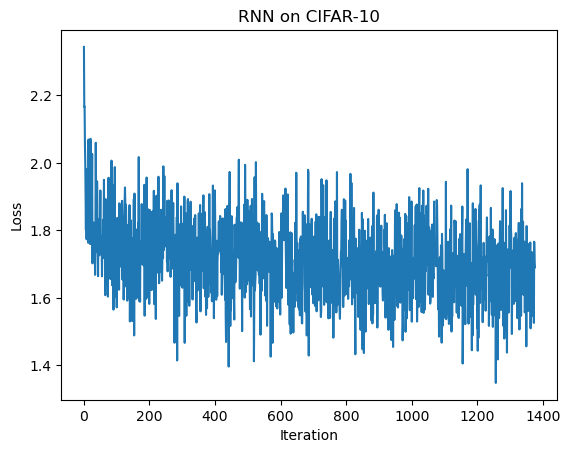

In [3]:
#画图
import matplotlib.pyplot as plt
x = np.linspace(1,1375,1375)
plt.plot(x, trainlos)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('RNN on CIFAR-10')
plt.show()

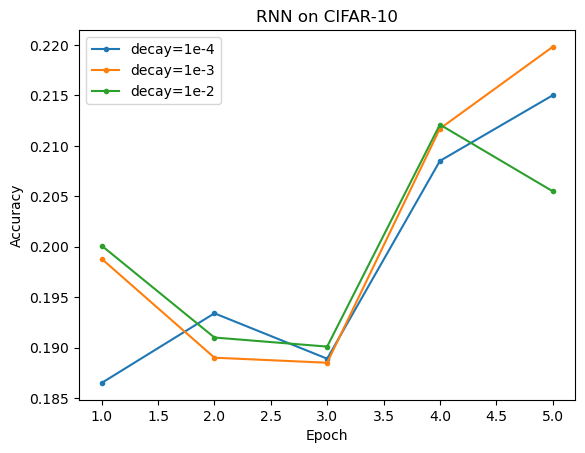

In [14]:
#画decay对模型的影响
x = [1, 2, 3, 4, 5]
y_4 = [0.1865,0.1934,0.1889,0.2085,0.215]
y_3 = [0.1988,0.189,0.1885,0.2117,0.2198]
y_2 = [0.2001,0.191,0.1901,0.2121,0.2055]
plt.plot(x, y_4,marker='o', markersize=3)
plt.plot(x, y_3,marker='o', markersize=3)
plt.plot(x, y_2,marker='o', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RNN on CIFAR-10')
plt.legend(['decay=1e-4', 'decay=1e-3', 'decay=1e-2'])
plt.show()